In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model as lm
from sklearn.utils import shuffle

In [129]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [130]:
class LinearRegression:
    def __init__(self, X, Y, learning_rate: float):
        X, Y = shuffle(X, Y)
        X, Y = np.array(X, dtype=float), np.array(Y)
        
        # X => Feature Vectors of training set
        self.m, self.n = X.shape # m => No. of training examples, n => No. of features
        
        # feature_stats => (mean, stddev) for each feature
        self.feature_stats = [(np.mean(feature), np.std(feature)) for feature in X.T]
        
        # Mean Normalizing the features
        self.mean_normalize(X)

        # Feature (column)Vectors, x0 = 1
        self.X = np.array([np.append(1, x).reshape(-1, 1) for x in X], dtype=float)
        self.Y = np.array(Y) # Output corresponding to each feature vector
        self.learning_rate = learning_rate
        self.theta = np.random.rand(self.n + 1, 1)
    

    def mean_normalize(self, X: np.ndarray):
        for i, (feature, (mean, stddev)) in enumerate(zip(X.T, self.feature_stats)):
            X.T[i] = (feature - mean) / stddev


    # x => Feature Vector with x0 = 1 (n + 1 dimensional column vector)
    def h(self, theta, x) -> float:
        return theta.T.dot(x)[0][0]
    
    # Cost Function
    def J(self, theta, X, Y) -> float:
        return (1 / len(X)) * sum((self.h(theta, x) - y) ** 2 for x, y in zip(X, Y))
    

    def has_converged(self, old_cost, new_cost) -> bool:
        return abs(old_cost - new_cost) < 10 ** -6

    # Returns the list 'cost' containing the costs after each gradient descent step.
    # Ideally it should be in the decreasing order.
    def gradient_descent(self):
        cost = [self.J(self.theta, self.X, self.Y)]

        while True:
            gradient_vector = (1 / self.m) * sum(
                (self.h(self.theta, x) - y) * x for x, y in zip(self.X, self.Y)
            )

            new_theta = self.theta - self.learning_rate * gradient_vector
            new_cost = self.J(new_theta, self.X, self.Y)

            if self.has_converged(cost[-1], new_cost):
                break

            self.theta = new_theta
            cost.append(new_cost)
        
        return cost


    def mini_batch_gradient_descent(self, batch_size=10):
        num_batches = self.m // batch_size
        cost = [0]
        while True:
            cur_cost = 0
            for i in range(0, self.m, batch_size):
                X_batch, Y_batch = self.X[i : i + batch_size], self.Y[i : i + batch_size]

                cur_cost += self.J(self.theta, X_batch, Y_batch)

                gradient_vector = (1 / len(X_batch)) * sum(
                    (self.h(self.theta, x) - y) * x for x, y in zip(X_batch, Y_batch)
                )

                self.theta = self.theta - self.learning_rate * gradient_vector
            
            avg_cost = cur_cost / num_batches
            
            if (self.has_converged(cost[-1], avg_cost)):
                break
            
            cost.append(avg_cost)
        
        return cost[1:]


    # X => Feature Vectors (list of n dimensional row vectors)
    def predict(self, X) -> float:
        X = np.array(X, dtype=float)
        # Mean Normalizing the Feature Vectors
        self.mean_normalize(X)
        X = [np.append(1, x).reshape(-1, 1) for x in X] # adding x0 = 1
        return [self.h(self.theta, x) for x in X]
    

    # Returns the Coefficient of determination R^2 for given X and Y
    # R^2 = 1 - (RSS / TSS), where RSS => Residual Sum of Squares and TSS => Total Sum of Squares
    # When the model predicts everything correctly, RSS = 0 and R^2 = 1
    # When the model predicts only the mean of Y, RSS = TSS which gives R^2 = 0
    def score(self, X, Y) -> float:
        pred_Y = self.predict(X)
        rss = sum((pred_Y - Y) ** 2)
        tss = sum((Y - np.mean(Y)) ** 2)
        return 1 - (rss / tss)

In [131]:
def visualize_gradient_descent(cost):
    ax = sns.lineplot(x=list(range(len(cost))), y=cost, marker='o')
    ax.set(xlabel='Iterations', ylabel='Cost', title='Cost vs Iterations')
    plt.show()

In [132]:
df = pd.read_csv('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


### Univariate Linear Regression

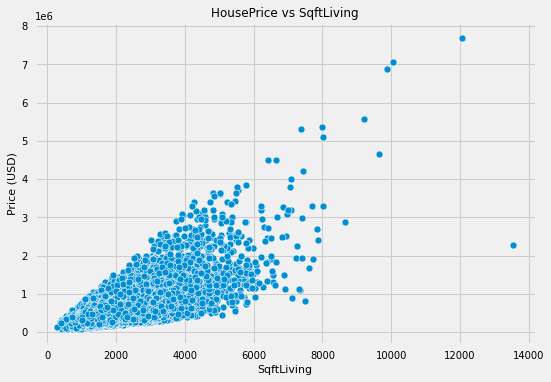

In [133]:
ax = sns.scatterplot(x='sqft_living', y='price', data=df)
ax.set(xlabel='SqftLiving', ylabel='Price (USD)', title='HousePrice vs SqftLiving')
plt.show()

In [134]:
X = np.array(list(zip(df['sqft_living'])))
Y = np.array(df['price'] / 10 ** 5)
X, Y

(array([[1180],
        [2570],
        [ 770],
        ...,
        [1020],
        [1600],
        [1020]]),
 array([2.219  , 5.38   , 1.8    , ..., 4.02101, 4.     , 3.25   ]))

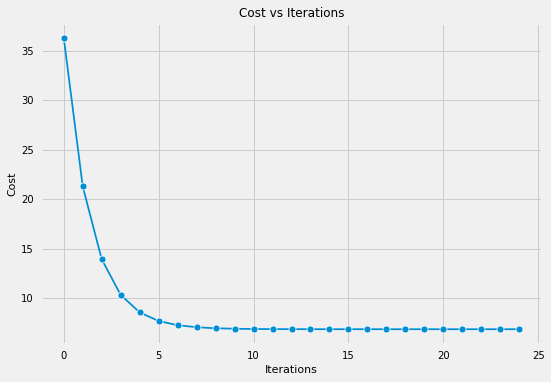

In [135]:
model = LinearRegression(X, Y, 0.3)
cost = model.gradient_descent()
visualize_gradient_descent(cost)

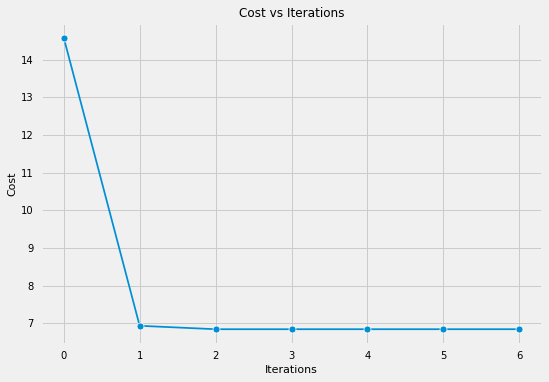

In [144]:
model1 = LinearRegression(X, Y, 0.001)
cost = model1.mini_batch_gradient_descent()
visualize_gradient_descent(cost)

In [146]:
model.theta, model1.theta

(array([[5.39988789],
        [2.57699291]]),
 array([[5.41327686],
        [2.60238574]]))

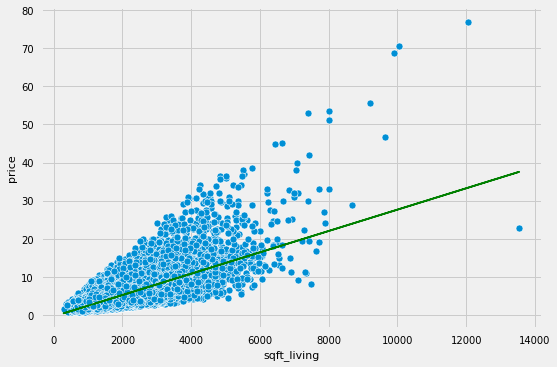

In [147]:
sns.scatterplot(x=df['sqft_living'], y=df['price'] / 10 ** 5)
plt.plot(X, model.predict(X), color='green')
plt.show()

In [139]:
b_model = lm.LinearRegression().fit(X, Y)
b_model.coef_, b_model.intercept_

(array([0.00280624]), -0.4358074309447355)

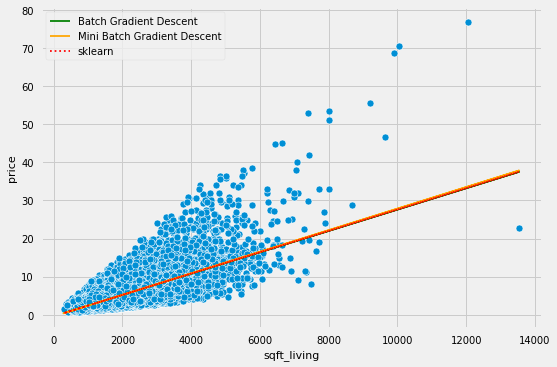

In [148]:
sns.scatterplot(x=df['sqft_living'], y=df['price'] / 10 ** 5)
plt.plot(X, model.predict(X), color='green', label='Batch Gradient Descent')
plt.plot(X, model1.predict(X), color='orange', label='Mini Batch Gradient Descent')
plt.plot(X, b_model.predict(X), color='red', linestyle='dotted', label='sklearn')
plt.legend()
plt.show()

In [145]:
print(f'Batch GD score = {model.score(X, Y)}')
print(f'Mini Batch GD score = {model1.score(X, Y)}')
print(f'sklearn score = {b_model.score(X, Y)}')

Batch GD score = 0.49285313757621785
Mini Batch GD score = 0.4927951333206466
sklearn score = 0.4928532179037932


### Multivariate Linear Regression

* Using more relavant features can yield better R^2 values
* Batch Gradient Descent took 34s while Mini Batch took only 8s

In [149]:
mul_X = np.array(list(zip(df['sqft_living'], df['bedrooms'], df['floors'], df['yr_built'])))
mul_X

array([[1.180e+03, 3.000e+00, 1.000e+00, 1.955e+03],
       [2.570e+03, 3.000e+00, 2.000e+00, 1.951e+03],
       [7.700e+02, 2.000e+00, 1.000e+00, 1.933e+03],
       ...,
       [1.020e+03, 2.000e+00, 2.000e+00, 2.009e+03],
       [1.600e+03, 3.000e+00, 2.000e+00, 2.004e+03],
       [1.020e+03, 2.000e+00, 2.000e+00, 2.008e+03]])

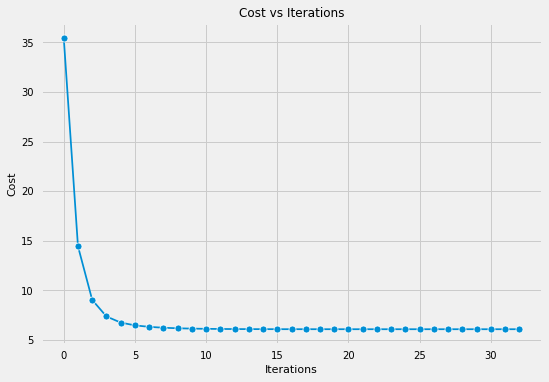

In [150]:
mul_model = LinearRegression(mul_X, Y, 0.5)
cost = mul_model.gradient_descent()
visualize_gradient_descent(cost)

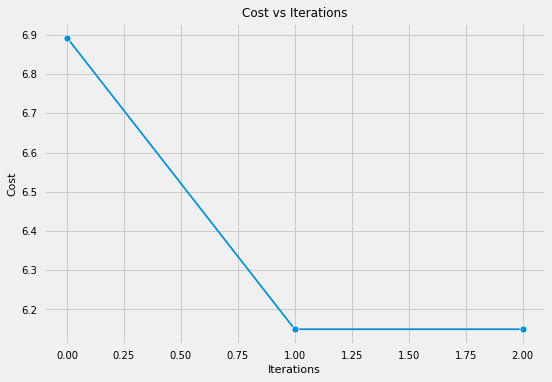

In [169]:
mul_model1 = LinearRegression(mul_X, Y, 0.01)
cost = mul_model1.mini_batch_gradient_descent()
visualize_gradient_descent(cost)

In [170]:
mul_model.theta, mul_model1.theta

(array([[ 5.40088142],
        [ 3.03257484],
        [-0.55047585],
        [ 0.3936823 ],
        [-0.87386681]]),
 array([[ 5.41995716],
        [ 3.08618361],
        [-0.42233239],
        [ 0.33193681],
        [-0.7946805 ]]))

The Above theta values suggest that:

* The price increases with increase in *sqft_living* and *floors*

* The price decreases with increase in *bedrooms* and *year_built*

In [153]:
b_mul_model = lm.LinearRegression().fit(mul_X, Y)

In [154]:
b_mul_model.intercept_, b_mul_model.coef_

(58.0996703940321, array([ 0.00330407, -0.59365938,  0.7283054 , -0.0297605 ]))

In [171]:
print(f'Batch GD score = {mul_model.score(mul_X, Y)}')
print(f'Mini Batch GD score = {mul_model1.score(mul_X, Y)}')
print(f'sklearn score = {b_mul_model.score(mul_X, Y)}')

Batch GD score = 0.5485601044079984
Mini Batch GD score = 0.5460616493126378
sklearn score = 0.548560300182119


### Polynomial Regression

* Batch Gradient Descent didn't converge even after running for 3 minutes.
* Whereas Mini Batch Gradient Descent converged after 16s

In [159]:
pol_X = np.array(list(zip(df['sqft_living'], df['sqft_living'] ** 2)))
pol_X

array([[   1180, 1392400],
       [   2570, 6604900],
       [    770,  592900],
       ...,
       [   1020, 1040400],
       [   1600, 2560000],
       [   1020, 1040400]])

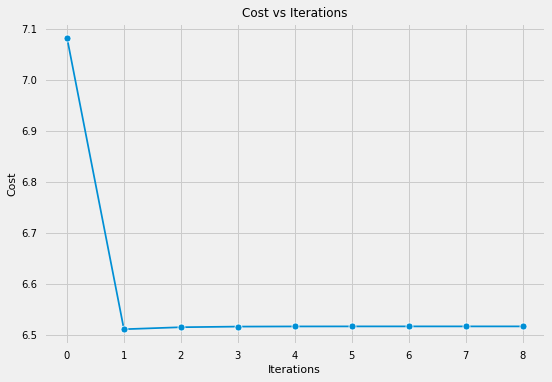

In [160]:
pol_model = LinearRegression(pol_X, Y, 0.01)
cost = pol_model.mini_batch_gradient_descent()
visualize_gradient_descent(cost)

In [161]:
pol_model.theta

array([[5.44049879],
       [0.5518967 ],
       [2.05427698]])

In [162]:
b_pol_model = lm.LinearRegression().fit(pol_X, Y)

In [163]:
b_pol_model.coef_, b_pol_model.intercept_

(array([6.79940947e-04, 3.85812609e-07]), 1.9922227930548417)

In [166]:
print('Batch GD Score = "Sucks!!!" (Did not terminate even after running 3 minutes)')
print(f'Mini Batch GD Score = {pol_model.score(pol_X, Y)}')
print(f'sklearn Score = {b_pol_model.score(pol_X, Y)}')

Batch GD Score = "Sucks!!!" (Did not terminate even after running 3 minutes)
Mini Batch GD Score = 0.5318421334794412
sklearn Score = 0.5327430940591444


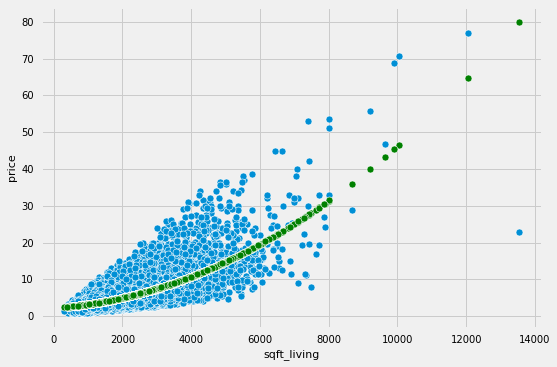

In [167]:
sns.scatterplot(x=df['sqft_living'], y=df['price'] / 10 ** 5)
sns.scatterplot(x=df['sqft_living'], y=pol_model.predict(pol_X), color='green')
plt.show()

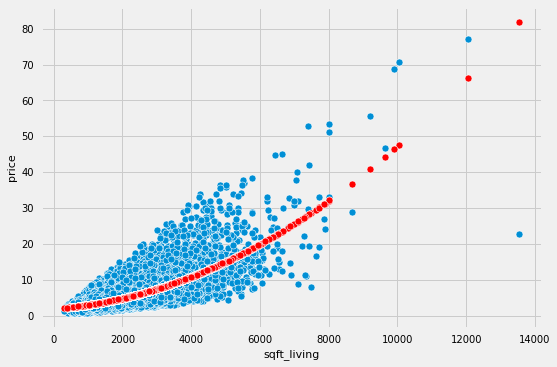

In [168]:
sns.scatterplot(x=df['sqft_living'], y=df['price'] / 10 ** 5)
sns.scatterplot(x=df['sqft_living'], y=b_pol_model.predict(pol_X), color='red')
plt.show()